In [40]:
%pylab inline
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib

Populating the interactive namespace from numpy and matplotlib


prep data

In [3]:
analytic_base = pd.read_csv('~/Repositories/datasets/analytic_base.csv')
analytic_qgiv = pd.read_csv('~/Repositories/datasets/analytic_qgiv_stats.csv')

ab = analytic_base[['id', 'org', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol']]
aq = analytic_qgiv[['id', 'base', 'org', 'total_visits', 'opt_fields', 'req_fields', 'donation_active', 'amounts_system', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_anonymous', 'permit_mobile', 'permit_other_amount', 'enable_donorlogins', 'collect_captcha']]
d = pd.merge(ab, aq, left_on="id", right_on="base")

In [4]:
# filter out not visited observations
data = d[d.visits > 0]
# add conversion
conversion = pd.DataFrame({'conversion':data["don_form_trans_count"]/data["total_visits"]*100})
# merge conversion w/ the rest of the data
data = pd.concat([data, conversion], axis=1)
# add day_of_month & month
date_data = pd.DataFrame({
        'day': pd.to_datetime(data.timestamp).apply(lambda x: x.day), 
        'month': pd.to_datetime(data.timestamp).apply(lambda x: x.month)})
# merge date data w/ the rest of the data
data = pd.concat([data, date_data], axis=1)

# add restrictionsXmultirestriction interaction term, restrictions^2, opt_fields^2, req_fields^2
data['restrictionsXmultirestriction'] = data.restrictions*data.multirestriction_system
data['restrictions2'] = data.restrictions*data.restrictions
data['restrictions2Xmultirestriction'] = data.restrictions2*data.multirestriction_system
data['restrictions3'] = data.restrictions*data.restrictions*data.restrictions
data['restrictions3Xmultirestriction'] = data.restrictions3*data.multirestriction_system
data['opt_fields2'] = data.opt_fields*data.opt_fields
data['opt_fields3'] = data.opt_fields*data.opt_fields*data.opt_fields
data['req_fields2'] = data.req_fields*data.req_fields
data['req_fields3'] = data.req_fields*data.req_fields*data.req_fields
data['fields'] = data['opt_fields'] + data['req_fields']
data['fields2'] = data['fields']*data['fields']
data['fields3'] = data['fields']*data['fields']*data['fields']

In [5]:
data['don_form_trans_vol'].fillna('0', inplace=True)
drop_features = ["id_x", "org_x", "form", "visits", "mobile_visits", "don_form_trans_count", 
                 "don_form_trans_vol", "id_y", "base", "org_y", "total_visits", "timestamp", "collect_captcha"]
df = data.drop(drop_features, axis=1)

In [6]:
column_list = df.columns.tolist()

for column in column_list:
    if column != "conversion":
        if df[column].dtype in ['float64', 'int64']:
            df[column] = (df[column] - df[column].mean()) / df[column].std()

In [7]:
print len(df)/4 * 3
df.isnull().sum()
print df.columns

427290
Index([u'opt_fields', u'req_fields', u'donation_active', u'amounts_system',
       u'multirestriction_system', u'restrictions', u'pledges_count',
       u'pledge_active', u'permit_anonymous', u'permit_mobile',
       u'permit_other_amount', u'enable_donorlogins', u'conversion', u'day',
       u'month', u'restrictionsXmultirestriction', u'restrictions2',
       u'restrictions2Xmultirestriction', u'restrictions3',
       u'restrictions3Xmultirestriction', u'opt_fields2', u'opt_fields3',
       u'req_fields2', u'req_fields3', u'fields', u'fields2', u'fields3'],
      dtype='object')


# Linear Regression fit performance

In [8]:
def linear_regression(df, target):
    # fit the linear regression
    reg = linear_model.LinearRegression()
    reg.fit(df.drop(target, axis=1), df[target])
    return reg

mdl = linear_regression(df[0:427290], "conversion")
scores = cross_val_score(mdl, df.drop("conversion", axis=1), df["conversion"], cv=5)

In [9]:
pred = mdl.predict(df.drop("conversion", axis=1)[427290:])
e = pred - df["conversion"][427290:]
print "MSE: "+str(pow(e, 2).mean())

MSE: 19.7981838379


In [10]:
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "COEFFICIENTS"
for i in range(0, len(df.drop("conversion", axis=1).columns)):
    print df.columns[i]+": "+str(mdl.coef_[i])

[-0.04320073 -0.00087044  0.          0.          0.        ]
Accuracy: -0.01 (+/- 0.03)
COEFFICIENTS
opt_fields: -2.35331997359e+12
req_fields: -1.2217681421e+12
donation_active: 0.7568359375
amounts_system: -0.414306640625
multirestriction_system: 0.416015625
restrictions: 1.86645507812
pledges_count: 0.0938110351562
pledge_active: -0.440490722656
permit_anonymous: -0.113342285156
permit_mobile: 0.184387207031
permit_other_amount: 0.0912780761719
enable_donorlogins: 0.494934082031
conversion: 0.0645222663879
day: -0.703857421875
month: 1.17391967773
restrictionsXmultirestriction: -4.23512268066
restrictions2: -1.40431213379
restrictions2Xmultirestriction: 2.40107727051
restrictions3: 0.863204956055
restrictions3Xmultirestriction: -7.47015380859
opt_fields2: 6.24523925781
opt_fields3: -4.18867492676
req_fields2: 5.75541687012
req_fields3: 2.78202995168e+12
fields: 7.28607177734
fields2: -6.70837402344


# Ridge Regression fit performance

In [11]:
def ridge_regression(df, target, alpha=0.5):
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(df.drop(target, axis=1), df[target])
    return reg

for i in [50.0, 40.0, 30.0, 25.0, 20.0, 15.0, 10.0, 5.0, 1.0]:
    mdl = ridge_regression(df[0:427290], "conversion", i)
    scores = cross_val_score(mdl, df.drop("conversion", axis=1), df["conversion"], cv=5)
    pred = mdl.predict(df.drop("conversion", axis=1)[427290:])
    e = pred - df["conversion"][427290:]
    print "Alpha: "+str(i)
    print "MSE: "+str(pow(e, 2).mean())
    print "------------------"

Alpha: 50.0
MSE: 17.6930864935
------------------
Alpha: 40.0
MSE: 17.9682315284
------------------
Alpha: 30.0
MSE: 18.2875807989
------------------
Alpha: 25.0
MSE: 18.4669041249
------------------
Alpha: 20.0
MSE: 18.6613214711
------------------
Alpha: 15.0
MSE: 18.872608126
------------------
Alpha: 10.0
MSE: 19.1028125513
------------------
Alpha: 5.0
MSE: 19.3543088652
------------------
Alpha: 1.0
MSE: 19.5726787252
------------------


In [12]:
pred = mdl.predict(df.drop("conversion", axis=1)[427290:])
e = pred - df["conversion"][427290:]
print "MSE: "+str(pow(e, 2).mean())

MSE: 19.5726787252


In [13]:
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "COEFFICIENTS"
for i in range(0, len(df.drop("conversion", axis=1).columns)):
    print df.columns[i]+": "+str(mdl.coef_[i])

[-0.04320137 -0.00087407  0.          0.          0.        ]
Accuracy: -0.01 (+/- 0.03)
COEFFICIENTS
opt_fields: 0.387998921787
req_fields: -0.0800607188711
donation_active: 0.751762322674
amounts_system: -0.403910220823
multirestriction_system: 0.403910220924
restrictions: 1.85673001334
pledges_count: 0.0937384335629
pledge_active: -0.437657474938
permit_anonymous: -0.118604929575
permit_mobile: 0.185230601067
permit_other_amount: 0.0899942288896
enable_donorlogins: 0.498635103818
conversion: 0.0644579561232
day: -0.704173628608
month: 1.22973849936
restrictionsXmultirestriction: -4.21928604564
restrictions2: -1.46720202188
restrictions2Xmultirestriction: 2.39422918429
restrictions3: 0.902974433138
restrictions3Xmultirestriction: -7.38643716167
opt_fields2: 6.15564717164
opt_fields3: -4.13070258371
req_fields2: 5.66634570635
req_fields3: 0.293048587373
fields: 7.03193516316
fields2: -6.47372945004


# Lasso fit performance

In [14]:
def lasso(df, target, alpha=0.1):
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(df.drop(target, axis=1), df[target])
    return reg

for i in [5.0, 2.0, 1.8, 1.5, 1.3, 1.0, 0.8, 0.5, 0.1]:
    mdl = lasso(df[0:427290], "conversion", i)
    scores = cross_val_score(mdl, df.drop("conversion", axis=1), df["conversion"], cv=5)
    pred = mdl.predict(df.drop("conversion", axis=1)[427290:])
    e = pred - df["conversion"][427290:]
    print "Alpha: "+str(i)
    print "MSE: "+str(pow(e, 2).mean())
    print "------------------"

Alpha: 20.0
MSE: 8.57784955253
------------------
Alpha: 15.0
MSE: 8.57784955253
------------------
Alpha: 10.0
MSE: 8.57784955253
------------------
Alpha: 5.0
MSE: 8.57784955253
------------------
Alpha: 2.0
MSE: 8.57784955253
------------------
Alpha: 1.8
MSE: 8.57784955253
------------------
Alpha: 1.5
MSE: 8.54938640747
------------------
Alpha: 1.3
MSE: 8.57020867007
------------------
Alpha: 1.0
MSE: 8.72153673554
------------------
Alpha: 0.8
MSE: 8.90130380853
------------------
Alpha: 0.5
MSE: 10.7253555037
------------------
Alpha: 0.1
MSE: 13.9920830439
------------------


*MSE levels off to a constant value after 1.8 where coefficients resolve to 0 and the prediction is also a constant value*

In [43]:
mdl = lasso(df[0:427290], "conversion", 0.1)
scores = cross_val_score(mdl, df.drop("conversion", axis=1), df["conversion"], cv=5)

print mdl.predict(df.drop("conversion", axis=1)[427290:427295])

[ 3.86352885  3.86352885  3.86352885  3.10865391  3.52216851]


In [44]:
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "COEFFICIENTS"
for i in range(0, len(df.drop("conversion", axis=1).columns)):
    print df.columns[i]+": "+str(mdl.coef_[i])

[-0.04553555 -0.00227422  0.          0.          0.        ]
Accuracy: -0.01 (+/- 0.04)
COEFFICIENTS
opt_fields: 0.134822023306
req_fields: -0.0
donation_active: 0.704378375798
amounts_system: -1.08955789525
multirestriction_system: 1.17529362792e-14
restrictions: 0.0
pledges_count: 0.046961030134
pledge_active: -0.307577382324
permit_anonymous: -0.00179608336604
permit_mobile: 0.176238939957
permit_other_amount: 0.000771048698884
enable_donorlogins: 0.48118247184
conversion: 0.0
day: -0.608351185392
month: 0.366506626023
restrictionsXmultirestriction: -0.0
restrictions2: -0.0
restrictions2Xmultirestriction: -0.0
restrictions3: -0.0223984466149
restrictions3Xmultirestriction: 0.0
opt_fields2: 0.0
opt_fields3: -0.0
req_fields2: -0.0
req_fields3: 0.0
fields: 0.0
fields2: 0.0


/Users/vsquared/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsquared/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsquared/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

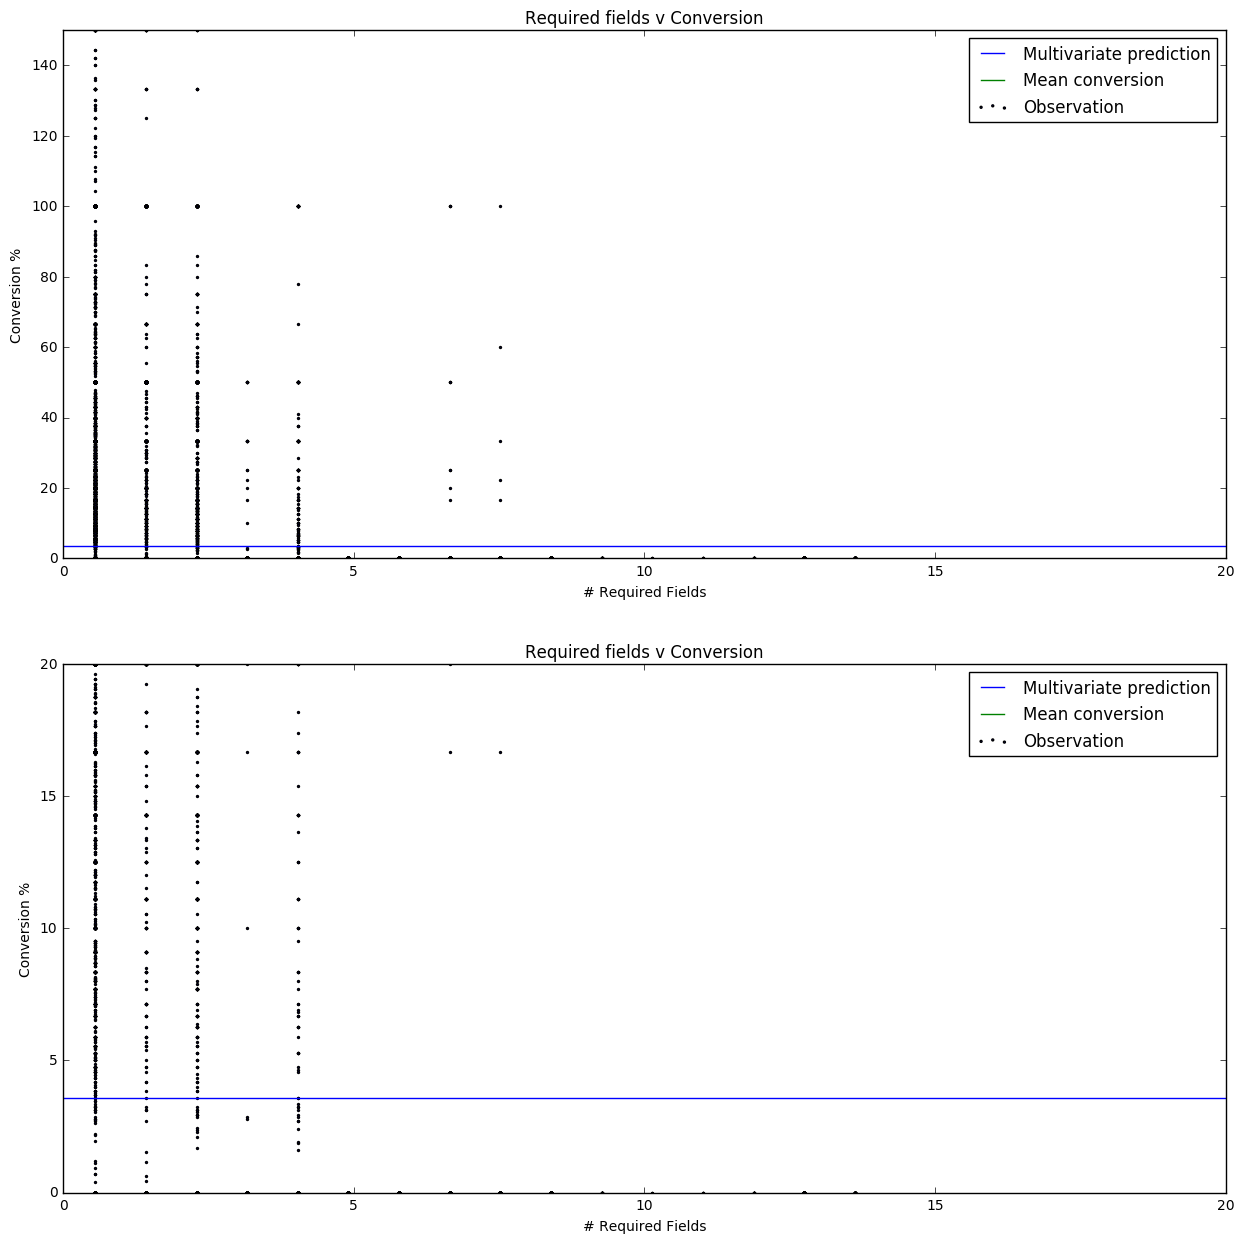

In [45]:
# generate prediction data
example = df[1:2]

predictions = []
for i in range(0, 200):
    example['req_fields'] = i
    example['req_fields2'] = i*i
    example['req_fields3'] = i*i*i
    example['fields'] = i+example['opt_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(mdl.predict(example.drop('conversion', axis=1))[0])

# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(df[df.req_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(df.req_fields, df.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Required fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Required Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(df.req_fields, df.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Required fields v Conversion")
xlim(0, 20)
ylim(0, 20)
xlabel('# Required Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()

# Bayesian Ridge Regression fit performance

In [17]:
def bayesian_ridge_regression(df, target):
    reg = linear_model.BayesianRidge()
    reg.fit(df.drop(target, axis=1), df[target])
    return reg

mdl = bayesian_ridge_regression(df[0:427290], "conversion")
scores = cross_val_score(mdl, df.drop("conversion", axis=1), df["conversion"], cv=5)

In [18]:
pred = mdl.predict(df.drop("conversion", axis=1)[427290:])
e = pred - df["conversion"][427290:]
print "MSE: "+str(pow(e, 2).mean())

MSE: 17.991488216


In [19]:
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "COEFFICIENTS"
for i in range(0, len(df.drop("conversion", axis=1).columns)):
    print df.columns[i]+": "+str(mdl.coef_[i])

[-0.04331958 -0.000945    0.          0.          0.        ]
Accuracy: -0.01 (+/- 0.03)
COEFFICIENTS
opt_fields: 0.389251668625
req_fields: -0.0399721978636
donation_active: 0.75252738443
amounts_system: -0.404995993345
multirestriction_system: 0.404995993351
restrictions: 1.78620154695
pledges_count: 0.0936721074134
pledge_active: -0.438655353161
permit_anonymous: -0.115222204356
permit_mobile: 0.186661467156
permit_other_amount: 0.0872824115149
enable_donorlogins: 0.500081506501
conversion: 0.0644995388647
day: -0.704101864994
month: 1.22881767963
restrictionsXmultirestriction: -4.02698907595
restrictions2: -1.45535542259
restrictions2Xmultirestriction: 2.26757433835
restrictions3: 0.893641288475
restrictions3Xmultirestriction: -6.09169735139
opt_fields2: 5.02786877533
opt_fields3: -3.44310982843
req_fields2: 4.57911197522
req_fields3: 0.311713742336
fields: 5.46310465098
fields2: -4.97969297328


# LARS Lasso fit performance

In [20]:
def lars_lasso(df, target):
    reg = linear_model.LassoLars(alpha=.1)
    reg.fit(df.drop(target, axis=1), df[target])
    return reg

mdl = lars_lasso(df[0:427290], "conversion")
scores = cross_val_score(mdl, df.drop("conversion", axis=1), df["conversion"], cv=5)

In [21]:
pred = mdl.predict(df.drop("conversion", axis=1)[427290:])
e = pred - df["conversion"][427290:]
print "MSE: "+str(pow(e, 2).mean())

MSE: 8.57784955253


In [22]:
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "COEFFICIENTS"
for i in range(0, len(df.drop("conversion", axis=1).columns)):
    print df.columns[i]+": "+str(mdl.coef_[i])

[-0.0517812  -0.01267778  0.          0.          0.        ]
Accuracy: -0.01 (+/- 0.04)
COEFFICIENTS
opt_fields: 0.0
req_fields: 0.0
donation_active: 0.0
amounts_system: 0.0
multirestriction_system: 0.0
restrictions: 0.0
pledges_count: 0.0
pledge_active: 0.0
permit_anonymous: 0.0
permit_mobile: 0.0
permit_other_amount: 0.0
enable_donorlogins: 0.0
conversion: 0.0
day: 0.0
month: 0.0
restrictionsXmultirestriction: 0.0
restrictions2: 0.0
restrictions2Xmultirestriction: 0.0
restrictions3: 0.0
restrictions3Xmultirestriction: 0.0
opt_fields2: 0.0
opt_fields3: 0.0
req_fields2: 0.0
req_fields3: 0.0
fields: 0.0
fields2: 0.0
